In [ ]:
# 라이브러리 
import os
import time
import copy
import glob
import cv2
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

In [ ]:
file_uploaded = files.upload() # 데이터 업로드

Saving catanddog.zip to catanddog.zip


In [ ]:
!unzip catanddog.zip -d catanddog/

In [ ]:
data_path = 'catanddog/train/'
transform = transforms.Compose(
    [
      transforms.Resize([256,256]),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor()
    ]
)
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)
print(len(train_dataset))

385


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


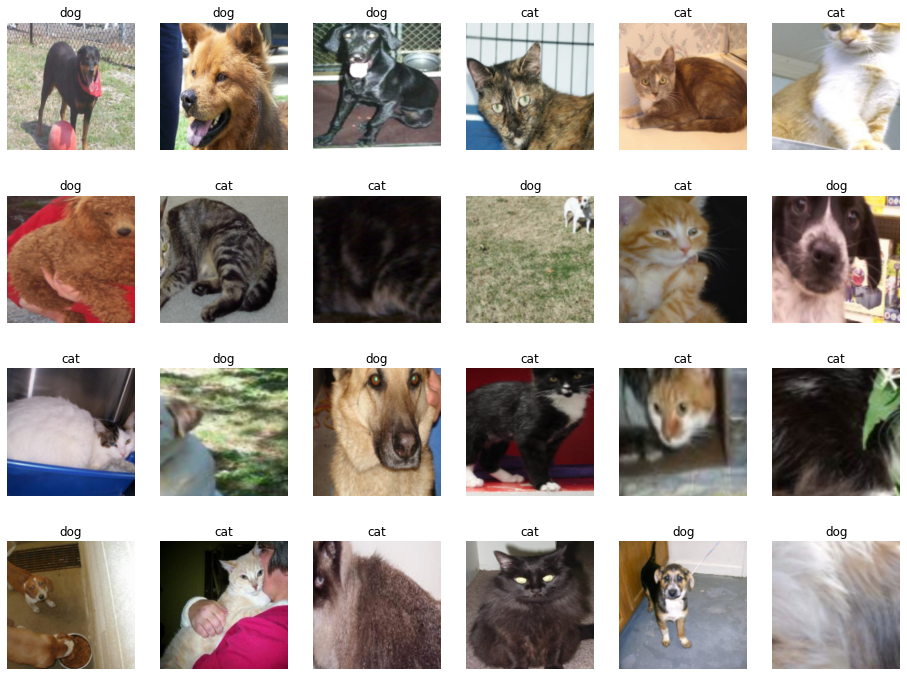

In [ ]:
# 이미지 데이터 확인
import numpy as np
samples,labels= iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(1, 24+1):
  a = fig.add_subplot(4,6,i)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(),(1,2,0)))
plt.subplots_adjust(bottom = 0.2, top=0.6,hspace=0)  

In [ ]:
# 전이학습
resnet18 = models.resnet18(weights=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# 기존에 학습된 가중치를 사용하되
# 파라메터에 대해선든 학습을 하지 않도록 고정
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False
set_parameter_requires_grad(resnet18)      

In [ ]:
# resnet18  (fc): Linear(in_features=512, out_features=1000, bias=True)  1000개의 분류 모델
# 여기에다가 마지작에 개 고양이 두개를 분리할수있도록 층을 교체 2진 분류 모델로 변경

In [ ]:
resnet18.fc = nn.Linear(in_features=512, out_features=2)

In [ ]:
# 파라메터 확인
for name,param in  resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0350,  0.0147, -0.0197,  ...,  0.0198,  0.0063, -0.0247],
        [-0.0312,  0.0162, -0.0366,  ..., -0.0220,  0.0365, -0.0135]])
fc.bias tensor([ 0.0268, -0.0184])


In [ ]:
model = models.resnet18(weights=True)
# 합성곱층 가중치 고정
for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=2)
# 추가한 완전 연결층은 학습
for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 파이퍼 파라메터
CFG = {
    'num_epochs':50
}
# CFG['num_epochs']

In [ ]:
# 모델 학습을 위한 함수 
def train_model(model, dataloaders,criterion, optimizer, device, num_epochs=13, is_train=True):
  since = time.time() # 현재시간
  acc_history = []
  loss_history = []
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    print('-'*10)
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)
      model.to(device)
      optimizer.zero_grad()  # 기울기를 0으로 설정
      outputs = model(inputs) # 순전파 학습
      loss = criterion(outputs, labels)
      _,preds = torch.max(outputs,1)
      loss.backward() # 역전파 학습
      optimizer.step()  # 옵티마이져 적용

      running_loss += loss.item()*inputs.size(0) # 출력결과와 레이블 오차를 계산한결과 누적
      running_corrects += torch.sum(preds == labels.data) # 동일한지
    epoch_loss = running_loss / len(dataloaders.dataset)  # 평균오차
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 평균 정확도

    print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      
    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)

    torch.save(model.state_dict(), os.path.join('catanddog/','{0:0=2d}.pth'.format(epoch)) )  # 모델 저장(재사용)
    print()
  time_elapsed = time.time() - since   # 소요시간 측정
  print(f"Training complete in {time_elapsed//60:.0f}m  {time_elapsed%60:.0f}s")
  print(f"Best Acc:{best_acc:4f}")
  return acc_history, loss_history

In [ ]:
params_to_update = []
# ResNet18에 추가된 완전연결층을 학습하도록 설정
# 이때 얻어지는 파라메터를 옵티마이져에 전달해서 최정적으로 모델 학습에 사용
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param) # 파라메터 학습결과 저장
    print('\t', name)
optimizer = optim.Adam(params_to_update)    # 학습결과를 옵티마이져에 전달

	 fc.weight
	 fc.bias


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() # 손실함수 지정
train_acc_hist, train_loss_hist =  train_model(resnet18,train_loader
                                               , criterion,optimizer,device, num_epochs=CFG['num_epochs'])

In [ ]:
# 정확도가 높으니 테스트 데이터로 확인

In [ ]:
test_path = 'catanddog/test/'
transform = transforms.Compose(
    [
      transforms.Resize([256,256]),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor()
    ]
)
test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)
print(len(train_dataset))

98


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# 테스트 데이터 준비완료
# 평가를 위한 함수
def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0
  saved_models = glob.glob('catanddog/*.pth')
  saved_models.sort()  # 정렬
  print(f"saved_model", saved_models)
  
  
  
  for model_path in saved_models:
    print(f"Loading model", model_path)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.no_grad(): # autograde를 사용하지 않겠다는 의미
        outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장
      _,preds = torch.max(outputs.data,1)
      preds[preds >= 0.5] = 1
      preds[preds < 0.5] = 0
      running_corrects += preds.eq(labels).int().sum()  
    epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 정확도 계산
    print(f"Acc : {epoch_acc:.4f}")
    if epoch_acc > best_acc:
      best_acc = epoch_acc
    acc_history.append(epoch_acc.item())
    print()
  time_elapsed = time.time() - since
  print(f"Testing complete in {time_elapsed//60:.0f}m  {time_elapsed%60:.0f}s")
  print(f"Best Acc:{best_acc:4f}")
  return acc_history


In [ ]:
#측정
val_acc_hist = eval_model(resnet18,test_loader,device)

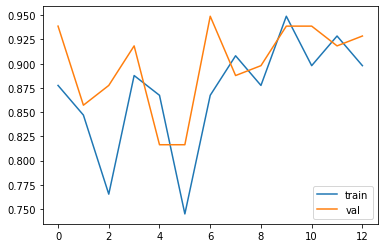

In [ ]:
# 결과 시각화
plt.plot(train_acc_hist,label = 'train')
plt.plot(val_acc_hist,label = 'val')
plt.legend()
plt.show()

In [ ]:
train_acc_hist

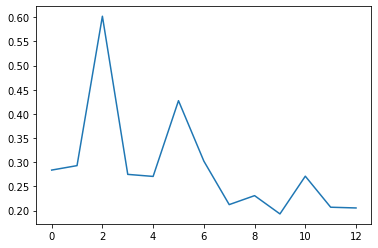

In [ ]:
# 오차정보를 그래프로 확인
plt.plot(train_loss_hist)
plt.show()

In [ ]:
# 실제 데이터 예측
# 실제 이미지를 출력하기 위한 전처리 함수
def im_convert(tensor):
  image = tensor.clone().detach().numpy()  # detach 기존 텐서에서 기울기가 전파되지 않는 텐서  
  #tensor.clone().detach() : 기존 텐서를 복사한 새로운 텐서를 생성하지만 기울기에 영향을 주지 않는다. 즉.. deep copy
  # tensor.clone() :  메모리 할당. 계산 그래프에 계속 상주
  # tensor.detach() : 공유해서 사용. 계산 그래프에  상주하지 않음
  # tensor.clone().detach() : 메모리 할당. 계산 그래프에  상주하지 않음
  image = image.transpose(1,2,0)
  image = image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)) )
  image = image.clip(0,1)
  return image

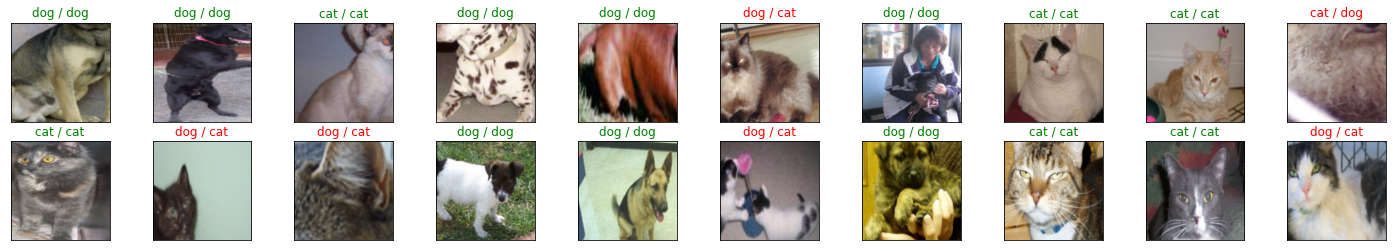

<Figure size 432x288 with 0 Axes>

In [ ]:
classes = {0:'cat', 1:'dog'}
dataiter = iter(test_loader)  # 테스트 데이터셋 가져오기
images, labels =  dataiter.next()
output = model(images)
_, preds = torch.max(output,1)
fig = plt.figure(figsize=(25,4))
for idx in range(1,20+1):
  ax = fig.add_subplot(2,10,idx, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))    
  ax.set_title(f"{str(classes[preds[idx].item() ])} / {str(classes[labels[idx].item() ])}"
  , color = ( 'green' if preds[idx] == labels[idx] else 'red') )
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [1]:
# 미세조정 기법
# 특성추출 보다 더 발전된방법으로 사전훈련된 모델과 합성곱층데이터 분류기의 가중치를 업데이트
# 사전 학습된 모델을 목적에 맞게 재 학습시키거나 학습된 가중치의 일부를 재 학습시키는 것 - 파라메터를 조정(gpu권장)


In [2]:
# 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을경우 
# 모델 전체를 재 학습시킴

In [3]:
# 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우
# 합성곱층의 뒷부분(완전연결층과 가까운 부분)과 데이터 분류기를 학습시킴

In [4]:
# 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을경우 
## 합성곱층의 일부분과 데이터분류기를 학습
## 데이터가 적기때문에 일부 계층에 미세조정 기법을 적용해도 효과가 없을수 있음
## 합성곱층 어디까지 새로 학습시켜야할지 적당히  설정해 줘야 함

In [5]:
# 데이터셋이 작고 사전 훈련된 모델과 유사성이 클경우 
## 데이터 분류기만 학습 - 데이터가 적기때문에 많은 계층에서 미세 조정기법을 적용하면 과적합

In [6]:
# 주의사항
# 파라메터 업데이트 과정에서 파라메터에 큰 변화를 주면 과적합 문제가 발생할수 있으므로 정교하고 미세한 파라메터 업데이트가 필요

In [7]:
# 특성맵 시각화 PIL을 install
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# 설명 가능한 CNN
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

In [39]:
from torch.nn.modules.linear import Linear
from torch.nn.modules import Sequential
# 설명 가능한 모델을 위해서.. 13개의 합성곱층과 두개의 완전연결층으로 구성된 네트웍을 생성
class XAI(torch.nn.Module):
  def __init__(self,num_classes=2):
    super(XAI,self).__init__()
    self.feature = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,bias=False ),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),  # 기존 데이터를 연산의 결과값으로 대체
        nn.Dropout(0.3),
        nn.Conv2d(64,64,kernel_size=3,bias=False ),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(64,128,kernel_size=3,bias=False ),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),  # 기존 데이터를 연산의 결과값으로 대체
        nn.Dropout(0.4),
        nn.Conv2d(128,128,kernel_size=3,bias=False ),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(128,256,kernel_size=3,bias=False ),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),  # 기존 데이터를 연산의 결과값으로 대체
        nn.Dropout(0.4),
        nn.Conv2d(256,256,kernel_size=3,bias=False ),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(256,512,kernel_size=3,bias=False ),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),  # 기존 데이터를 연산의 결과값으로 대체
        nn.Dropout(0.4),
        nn.Conv2d(512,512,kernel_size=3,bias=False ),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.claasifier = nn.Sequential(
      nn.Linear(512,512,bias=False),
      nn.Dropout(0.5),
      nn.BatchNorm1d(512),
      nn.ReLU(inplace=True),
      nn.Dropout(0.5),
      nn.Linear(512,num_classes)
    )
  def forward(self, x):
    x = self.feature(x)
    x = x.view(-1,512)
    x = self.claasifier(x)
    return F.log_softmax(x)  #  신경망 말단의 결과 값들을 확률 개념으로 해석하기 위해 소프트맥스에 log 값을 취한연산 
    # 일반 소프트맥스는 기울기 소멸문제에 취약하기 때문


    

In [40]:
model = XAI()
model.to('cpu')
model.eval() # 테스트 데이터에대한 모델 평가용도로 사용

XAI(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, pa

In [14]:
# (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False) 에 대한 특성 맵을 확인하기 위한 클래스를 정의

In [15]:
class LayerActivations:
  features = []
  def __init__(self,model,layer_num) -> None:
    self.hook = model[layer_num].register_forward_hook(self.hook_fn)  # 파이토치는 매 계층마다 print를  사용하지 않아도 hook기능을
    # 이용해서 각 계층의 활성화 함수나 기울기 값을 확인
    # 순전파 중에 각 네트워크 모듈의 입력 및 출력을 가져오기위함
  def hook_fn(self,module,input,output):
    self.features = output.detach().numpy()
  def remove(self): # hook 삭제
    self.hook.remove


In [18]:
x = torch.Tensor([0,1,2,3]).requires_grad_()
y = torch.Tensor([4,5,6,7]).requires_grad_()
w = torch.Tensor([1,2,3,4]).requires_grad_()
z = x + y
o = w.matmul(z)
o.backward()
x.grad,y.grad,z.grad,w.grad,o.grad

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


(tensor([1., 2., 3., 4.]),
 tensor([1., 2., 3., 4.]),
 None,
 tensor([ 4.,  6.,  8., 10.]),
 None)

In [19]:
from google.colab import files
file_uploaded =  files.upload()

Saving 8100.jpg to 8100.jpg


(499, 500, 3)


torch.Size([1, 3, 100, 100])

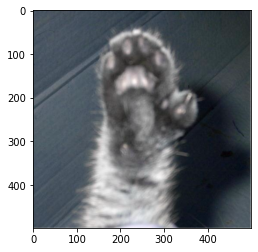

In [35]:
img = cv2.imread('/content/8100.jpg')
print(img.shape)
plt.imshow(img)
img = cv2.resize(img,(100,100), interpolation=cv2.INTER_LINEAR) # interpolation 이미지의 사이즈를 변경할때 오류방지
img = ToTensor()(img).unsqueeze(0) # 1차원 데이터를 생성하는 함수  즉 이미지를 텐서로 변경하고 그 데이터를 1차원으로 변경
img.shape

In [41]:
# 레이어의 0번째 에 대한 특성 맵을 확인
result = LayerActivations( model.feature,0)
model(img)
activations = result.features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [47]:
activations[0].shape

(64, 98, 98)

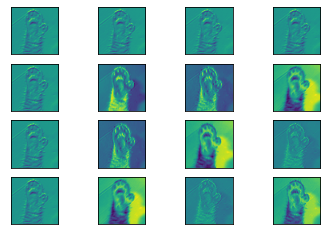

<Figure size 864x576 with 0 Axes>

In [48]:
# 특성맵을 시각화
fig,axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for row in range(4):
  for cols in range(4):
    axis = axes[row][cols]
    axis.get_xaxis().set_ticks([]) # 숫자 제거
    axis.get_yaxis().set_ticks([]) # 숫자 제거
    axis.imshow(activations[0][row*cols])
plt.show()    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


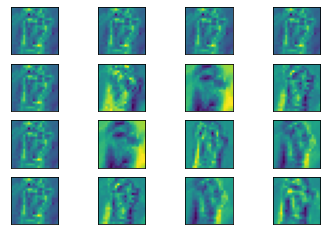

<Figure size 864x576 with 0 Axes>

In [49]:
# 학습이 진행될수록 이미지의 변화를 확인할수 있도록 16번째 28번째 특성맵
result = LayerActivations( model.feature,16)
model(img)
activations = result.features
# 특성맵을 시각화
fig,axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for row in range(4):
  for cols in range(4):
    axis = axes[row][cols]
    axis.get_xaxis().set_ticks([]) # 숫자 제거
    axis.get_yaxis().set_ticks([]) # 숫자 제거
    axis.imshow(activations[0][row*cols])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


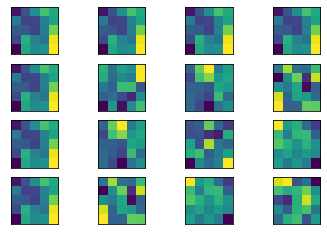

<Figure size 864x576 with 0 Axes>

In [50]:
# 학습이 진행될수록 이미지의 변화를 확인할수 있도록 16번째 28번째 특성맵
result = LayerActivations( model.feature,28)
model(img)
activations = result.features
# 특성맵을 시각화
fig,axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
for row in range(4):
  for cols in range(4):
    axis = axes[row][cols]
    axis.get_xaxis().set_ticks([]) # 숫자 제거
    axis.get_yaxis().set_ticks([]) # 숫자 제거
    axis.imshow(activations[0][row*cols])
plt.show()

In [ ]:
# 출력층에 가까워질수록 원래 형태는 찾아볼수 없고 이미지 특징들만 전달되는것을 확인